<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/1%20ch(5.%20Fc4)v4-1%20_%20Dropout(0.5%20with%20regularizations).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

'''
1 channel :  Fc4 (index = 5)

layers: 3 conv2D(3,3) & maxpooling(2,2) - 1 Dense(512, regularizers)
epoch: 50 
batch size: 20

test acc: 0.81051
test loss: 0.6805

'''


import matplotlib

from matplotlib import pyplot as plt
import numpy as np


import random
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
#from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)


1 channel :  Fc4 (index = 5)

layers: 3 conv2D(3,3) & maxpooling(2,2) - 1 Dense(512)
epoch: 50 
batch size: 20

test acc: 
test loss: 




In [4]:
subject_number=20


# load dataset in array
list_raw_fnames = [[0]*2]*subject_number
for x in range(subject_number):
    list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,[1,2])

list_rawdata1 = np.zeros((subject_number,2), dtype='object')
list_rawdata = np.zeros((subject_number,2), dtype='object')

for i in range(subject_number):
    for j in range(2):
        list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)

Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data
[........................................] 100.00% (  1.2 MB,  19.1 MB/s) |   
Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
[........................................] 100.00% (  1.2 MB,  17.2 MB/s) \   
[........................................] 100.00% (  1.2 MB,  22.3 MB/s) |   
[........................................] 100.00% (  1.2 MB,  20.9 MB/s) \   
[........................................] 100.00% (  1.2 MB,  20.3 MB/s) \   
[........................................] 100.00% (  1.2 MB,  13.9 MB/s) \   
[........................................] 100.00% (  1.2 MB,  24.1 MB/s) |   
[........................................] 100.00% (  1.2 MB,  12.6 MB/s) \   
[........................................] 100.00% (  1.2 MB,  22.5 MB/s) |   
[....................

In [24]:
import math


task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
sample_shift = 4 #step len
window_len= 20
list_channel = [5] # channel = Fc4

# img for each one
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec) / sample_shift) +1 - window_len +1
test_start_index=subject_img_number - math.floor(subject_img_number/4) 

train_number =  test_start_index 
test_number = subject_img_number - test_start_index
train_number

1757

In [25]:
ch_number = len(list_channel)

train_img = np.zeros((train_number*subject_number, ch_number, window_len + 1, 160), dtype = float)
train_label =[]


test_img = np.zeros((test_number*subject_number, ch_number, window_len, 160), dtype = float)
test_label =[]


train_img.shape

(35140, 1, 21, 160)

In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

In [0]:
for s in range(subject_number):
    ch_max =[]
    ch_min =[]
    for ch in list_channel:
      rawdataChannels_t, times_t =list_rawdata[s][0][ch,:9600]
      #print(rawdataChannels_t)
      ch_max = np.append(ch_max, max(rawdataChannels_t[0])) # max for each cannel
      ch_min = np.append(ch_min, min(rawdataChannels_t[0])) # min for each cannel
    
    for j in range (subject_img_number):
        i = 0
        for index in list_channel: # فقط کانال های با اندیس مشخص را دربرمیگیرد
            
            for z in range (window_len):
                rawdataChannels, times =list_rawdata[s][0][index, (j+z)*sample_shift:sampel_number_per_sec+(j+z)*sample_shift]

                      # normalize method
                rawdataChannels = normalize_channel_data(rawdataChannels, i, ch_min, ch_max)
                if j <test_start_index :
                    train_img[s*train_number + j][i][z] = rawdataChannels
                    if z==window_len-1 :
                      train_img[s*train_number + j][i][z+1] = s
                      
                      
                else:
                    test_img[s*test_number + j - test_start_index][i][z] = rawdataChannels
            i+=1            
                    
              
        if j >=test_start_index :
          test_label = np.append(test_label, (s))

In [0]:
#shaffle train img array
train_img_shuffle = train_img

np.random.shuffle(train_img_shuffle)

In [0]:
train_img_2 = np.zeros((train_number*subject_number, ch_number, window_len, 160), dtype = float)

# img label 
train_img_shuffle_len =len(train_img_shuffle)
for i in range(train_img_shuffle_len):
    train_label = np.append(train_label, (train_img_shuffle[i][0][window_len][0] ))
    for j in range (ch_number):
      train_img_2[i][j] = np.delete(train_img_shuffle[i][j], window_len, axis=0)

In [0]:
from keras.utils import to_categorical


In [0]:
train_label = to_categorical(train_label, subject_number)
test_label = to_categorical(test_label, subject_number)

In [32]:
# valid & train
x_train =train_img_2[:25000]
y_train =train_label[:25000]

x_valid =train_img_2[25000:]
y_valid =train_label[25000:]

x_valid.shape

(10140, 1, 20, 160)

In [33]:
train_label[:10]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [34]:
from keras import layers
from keras import models
from keras import regularizers


model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (ch_number,window_len,160), data_format= "channels_first" ))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))
print(model.output.shape)
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
print(model.output.shape)
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Flatten())
print(model.output.shape)
model.add(layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
print(model.output.shape)
model.add(layers.Dense(subject_number, activation = 'softmax'))
print(model.output.shape)

(?, 64, 20, 160)
(?, 32, 10, 160)
(?, 30, 8, 128)
(?, 15, 4, 128)
(?, 13, 2, 256)
(?, ?)
(?, 512)
(?, 20)


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 20, 160)       640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 10, 160)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 8, 128)        184448    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 4, 128)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 2, 256)        295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 1, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
__________

In [0]:
from keras import optimizers

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

In [37]:
history = model.fit(
        x_train,
        y_train,
        epochs = 15,
        batch_size = 20,
        validation_data = (x_valid, y_valid)
)

Train on 25000 samples, validate on 10140 samples
Epoch 1/15
25000/25000 [==============================] - 366s 15ms/step - loss: 3.6085 - acc: 0.2329 - val_loss: 1.8420 - val_acc: 0.5323
Epoch 2/15
25000/25000 [==============================] - 368s 15ms/step - loss: 1.5573 - acc: 0.5541 - val_loss: 1.1102 - val_acc: 0.6955
Epoch 3/15
25000/25000 [==============================] - 366s 15ms/step - loss: 1.1643 - acc: 0.6614 - val_loss: 0.8940 - val_acc: 0.7575
Epoch 4/15
25000/25000 [==============================] - 367s 15ms/step - loss: 0.9680 - acc: 0.7103 - val_loss: 0.7769 - val_acc: 0.7700
Epoch 5/15
25000/25000 [==============================] - 368s 15ms/step - loss: 0.8577 - acc: 0.7443 - val_loss: 0.7459 - val_acc: 0.7725
Epoch 6/15
25000/25000 [==============================] - 367s 15ms/step - loss: 0.7834 - acc: 0.7655 - val_loss: 0.6341 - val_acc: 0.8204
Epoch 7/15
25000/25000 [==============================] - 368s 15ms/step - loss: 0.7195 - acc: 0.7864 - val_loss: 0.

In [38]:
model.evaluate(test_img, test_label)

11700/11700 [==============================] - 46s 4ms/step


[0.6805644272000362, 0.8105128205128205]

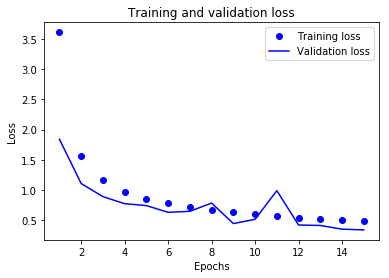

In [39]:
import matplotlib.pyplot as plt

history_dict = history.history 

loss_values = history_dict ['loss'] 

val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)



plt.plot(epochs, loss_values, 'bo', label='Training loss') 

plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 

plt.title('Training and validation loss') 

plt.xlabel('Epochs') 

plt.ylabel('Loss') 

plt.legend()

plt.show()

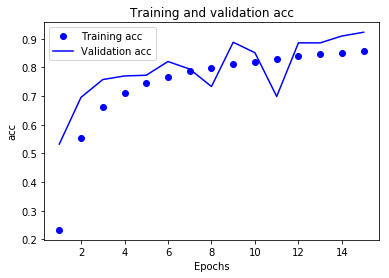

In [40]:
history_dict = history.history 

acc_values = history_dict ['acc'] 

val_acc_values = history_dict['val_acc']



plt.plot(epochs, acc_values, 'bo', label='Training acc') 

plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 

plt.title('Training and validation acc') 

plt.xlabel('Epochs') 

plt.ylabel('acc') 

plt.legend()

plt.show()